In [1]:
import scipy.optimize as optimization
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline    

In [6]:
def func(x,threshold,b1,b2,a1):
    # a1, b1 are slope and intercept for left curve
    # b2 is slope for right curve
    # intercept on right curve is determined by the intersection constraint
    a2 = (b1*threshold - b2*threshold + a1)
    return np.where(x<threshold, b1*x+a1, b2*x+a2)
    
def broken_stick_fit(x, y, 
                    threshold_lower_percentile_bound=0,
                    threshold_upper_percentile_bound=100, 
                    slope_left_lower = -np.inf, 
                    slope_left_upper = np.inf,
                    slope_right_lower = -np.inf,
                    slope_right_upper = np.inf
                    ):
    """
    @desc:
    Fits broken stick, with constraints if desired. Note, if using for CQ power law fits, data should first
    be log-transformed.
    
    @params:
    threshold_upper_percentile: upper bound on possible thresholds determined through a percentile on the x data
    threshold_lower_percentile: lower bound on possible thresholds determined through a percentile on the x data
    slope_left_lower: lower constraint on left slope
    slope_left_upper: upper constraint on left slope
    slope_right_lower: lower constraint on right slope
    slope_right_upper: upper constraint on right slope
    
    @returns:
    popt: fitted broken stick paramters as a list
        [threshold: threshold for slope break, 
        b1: slope on left line, 
        b2: slope on right line,
        a1: intercept on left line]
        Note that if the curves intersect, the intercept on the right curve is constrained by the other fits
        a2 = (b1*threshold - b2*threshold + a1)
    standard_errors: standard errors for the fitted parameters
    """

    
    popt, pcov = optimization.curve_fit(func, x, y, 
                                    bounds = [(np.percentile(x,threshold_lower_percentile_bound), slope_left_lower, slope_right_lower, -np.inf), 
                                              (np.percentile(x,threshold_upper_percentile_bound), slope_left_upper, slope_right_upper, np.inf)
                                             ]
                                   )
    standard_errors = np.sqrt(np.diag(pcov))
    return popt, standard_errors

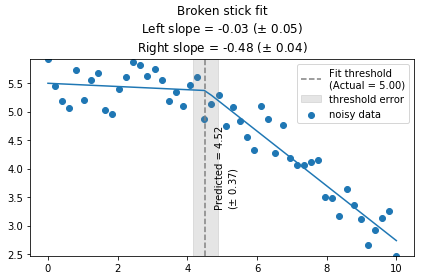

In [19]:
# generate some fake broken curve data
# with a threshold at 5
# left slope of -0.05
# right slope -0.5
# and some gaussian noise
x = np.linspace(0,10)
actualthreshold = 5
y = func(x,actualthreshold,-.05,-.5,5)
y = y + np.random.rand(len(y))
plt.scatter(x,y, label='noisy data')

# if desired, constrain threshold (so that don't get weird breaks in noisy data)
# or constrain fitted slopes
upper = 75
lower = 25

params, ses = broken_stick_fit(x,y, lower, upper)
[threshold, b1, b2, a1] = params
[se_threshold, se_leftslope, se_rightslope, se_leftintercept] = ses

ypredict = func(x,threshold, b1, b2, a1)
plt.plot(x,ypredict)
plt.plot([threshold, threshold], 
         [np.min(y), np.max(y)], '--', lw=1.5, c='grey', 
         label='Fit threshold\n(Actual = %.2f)'%(actualthreshold)
        )
plt.ylim([np.min(y), np.max(y)])
plt.axvspan(xmin=threshold - se_threshold, 
            xmax=threshold + se_threshold,
            color='grey',alpha=0.2, 
            label='threshold error'
           )
plt.legend()
plt.annotate('\nPredicted = %.2f\n($\pm$ %.2f)'%(threshold, se_threshold), (threshold, np.min(y)+(np.max(y)-np.min(y))/2), fontsize=10, rotation=90)
plt.title('Broken stick fit\nLeft slope = %.2f ($\pm$ %.2f)\nRight slope = %.2f ($\pm$ %.2f)'%(b1,se_leftslope, b2, se_rightslope))
plt.tight_layout()